# SSD: Single Shot MultiBox Detector

This is designed to visualize score maps of trained model. Modified from 00-classification.ipynb.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load caffe

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### 2. Load net and set up input preprocessing

* Set Caffe to GPU mode and load the net from disk.

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

model_def = '../../models/SSD_300x300_intra_level_iter_3_conv4_3/test.prototxt'
model_weights = '../../models/SSD_300x300_intra_level_iter_3_conv4_3/models/VGG_VOC0712_SSD_300x300_iter_40000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [4]:
### perform detection
output = net.forward()

### 3. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [5]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(2, 3, 300, 300)
label	(1, 1, 3, 8)
data_data_0_split_0	(2, 3, 300, 300)
data_data_0_split_1	(2, 3, 300, 300)
data_data_0_split_2	(2, 3, 300, 300)
data_data_0_split_3	(2, 3, 300, 300)
data_data_0_split_4	(2, 3, 300, 300)
data_data_0_split_5	(2, 3, 300, 300)
data_data_0_split_6	(2, 3, 300, 300)
data_data_0_split_7	(2, 3, 300, 300)
conv1_1	(2, 64, 300, 300)
conv1_2	(2, 64, 300, 300)
pool1	(2, 64, 150, 150)
conv2_1	(2, 128, 150, 150)
conv2_2	(2, 128, 150, 150)
pool2	(2, 128, 75, 75)
conv3_1	(2, 256, 75, 75)
conv3_2	(2, 256, 75, 75)
conv3_3	(2, 256, 75, 75)
pool3	(2, 256, 38, 38)
conv4_1	(2, 512, 38, 38)
conv4_2	(2, 512, 38, 38)
conv4_3	(2, 512, 38, 38)
conv4_3_relu4_3_0_split_0	(2, 512, 38, 38)
conv4_3_relu4_3_0_split_1	(2, 512, 38, 38)
pool4	(2, 512, 19, 19)
conv5_1	(2, 512, 19, 19)
conv5_2	(2, 512, 19, 19)
conv5_3	(2, 512, 19, 19)
pool5	(2, 512, 19, 19)
fc6	(2, 1024, 19, 19)
fc7	(2, 1024, 19, 19)
fc7_relu7_0_split_0	(2, 1024, 19, 19)
fc7_relu7_0_split_1	(2, 1024, 19, 19)
fc7_relu7_

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [6]:
for layer_name, param in net.params.iteritems():
    item = layer_name + '\t'
    for i in xrange(len(param)):
        item = item + str(param[i].data.shape) + ' '
    print item

conv1_1	(64, 3, 3, 3) (64,) 
conv1_2	(64, 64, 3, 3) (64,) 
conv2_1	(128, 64, 3, 3) (128,) 
conv2_2	(128, 128, 3, 3) (128,) 
conv3_1	(256, 128, 3, 3) (256,) 
conv3_2	(256, 256, 3, 3) (256,) 
conv3_3	(256, 256, 3, 3) (256,) 
conv4_1	(512, 256, 3, 3) (512,) 
conv4_2	(512, 512, 3, 3) (512,) 
conv4_3	(512, 512, 3, 3) (512,) 
conv5_1	(512, 512, 3, 3) (512,) 
conv5_2	(512, 512, 3, 3) (512,) 
conv5_3	(512, 512, 3, 3) (512,) 
fc6	(1024, 512, 3, 3) (1024,) 
fc7	(1024, 1024, 1, 1) (1024,) 
conv6_1	(256, 1024, 1, 1) (256,) 
conv6_2	(512, 256, 3, 3) (512,) 
conv7_1	(128, 512, 1, 1) (128,) 
conv7_2	(256, 128, 3, 3) (256,) 
conv8_1	(128, 256, 1, 1) (128,) 
conv8_2	(256, 128, 3, 3) (256,) 
conv9_1	(128, 256, 1, 1) (128,) 
conv9_2	(256, 128, 3, 3) (256,) 
conv4_3_norm	(512,) 
conv4_3_norm_mbox_loc	(16, 512, 3, 3) (16,) 
conv4_3_norm_mbox_conf	(84, 512, 3, 3) (84,) 
conv4_3_norm_mbox_conf_prior_1_Q_hat	(1, 1, 21, 21) (1, 1, 21, 21) (1, 1, 21, 21) 
conv4_3_norm_mbox_conf_prior_2_Q_hat	(1, 1, 21, 21) (1, 

* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [7]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data);
    plt.axis('off')

* First we'll look at the first layer filters, `conv1_1`

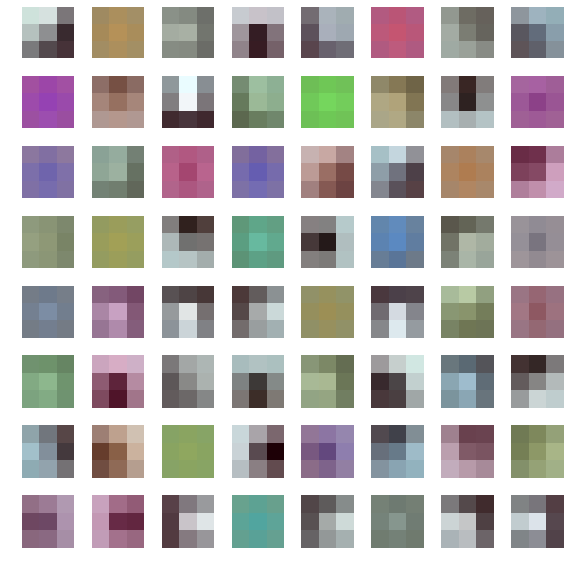

In [8]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [9]:
item_id = 1

(3, 300, 300)


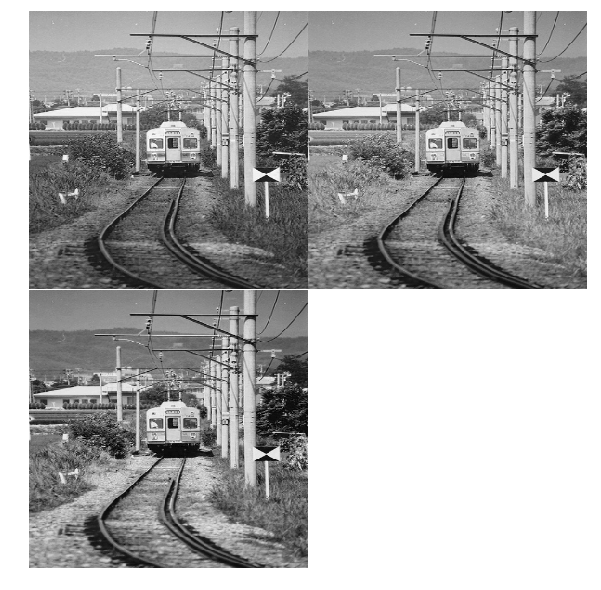

In [10]:
data = net.blobs['data'].data[item_id]
print data.shape
vis_square(data)

(21, 38, 38)


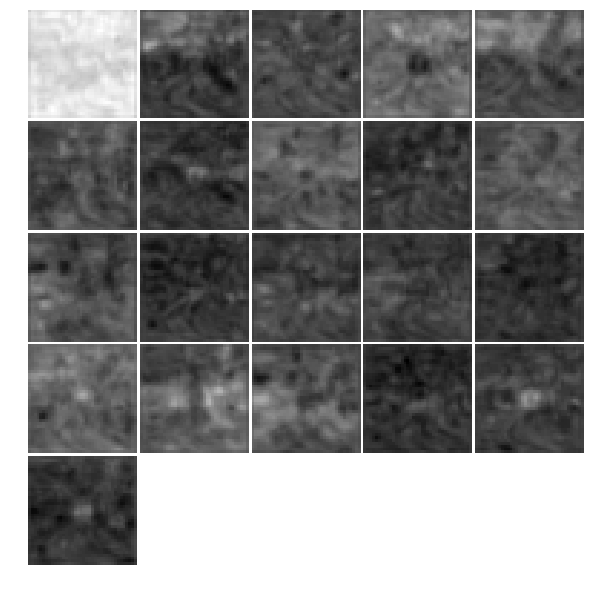

In [11]:
unary_term = net.blobs['conv4_3_norm_mbox_conf_prior_1_unary'].data[item_id]
print unary_term.shape
vis_square(unary_term)

(21, 38, 38)


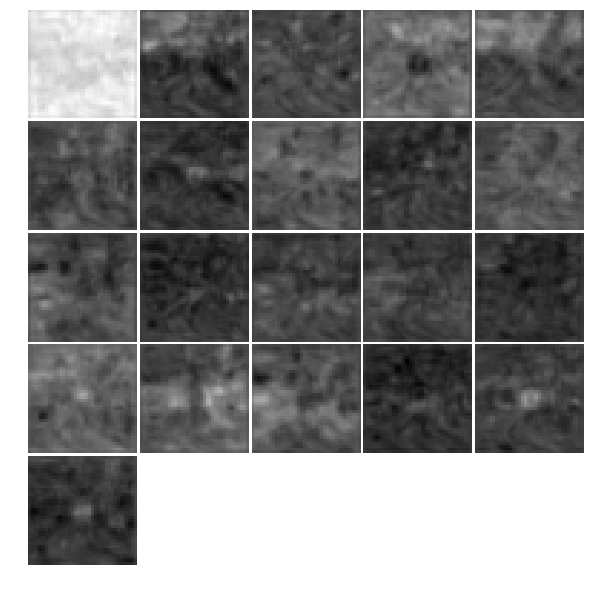

In [12]:
Q = net.blobs['conv4_3_norm_mbox_conf_prior_1_Q_hat'].data[item_id]
print Q.shape
vis_square(Q)

(42, 38, 38)


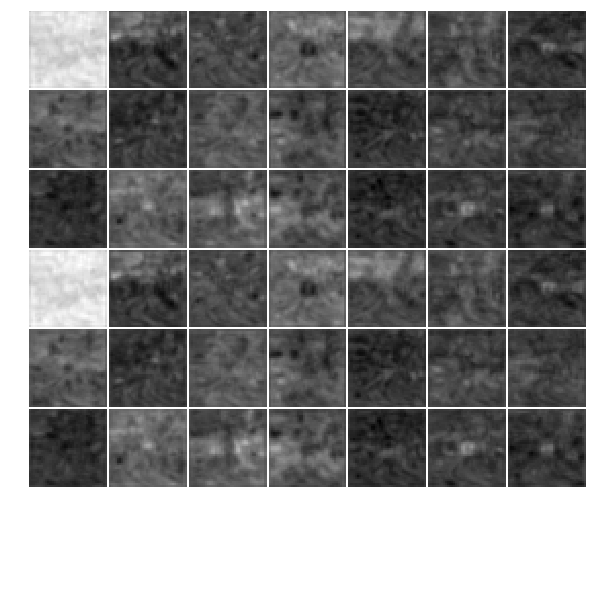

In [13]:
combined = np.concatenate((unary_term, Q))
print combined.shape
vis_square(combined)